In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as gp
import plotly.express as px

from sklearn import svm
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline


## Import data

In [2]:
# Dataset from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# check null
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [6]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
# check id is unique
len(df.id.unique())

5110

In [8]:
# set id as index
df.set_index('id', inplace=True)
df

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
...       ...   ...           ...            ...          ...            ...   
18234  Female  80.0             1              0          Yes        Private   
44873  Female  81.0             0              0          Yes  Self-employed   
19723  Female  35.0             0              0          Yes  Self-employed   
37544    Male  51.0             0              0          Yes        Private   
44679  Female  44.0             0              0          Yes       Govt_job   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1  
...              ...                ...   ...              ...     ...  
18234          Urban              83.75   NaN     never smoked       0  
44873          Urban             125.20  40.0     never smoked       0  
19723          Rural              82.99  30.6     never smoked       0  
37544          Rural             166.29  25.6  formerly smoked       0  
44679          Urban              85.28  26.2          Unknown       0  

[5110 rows x 11 columns]

In [9]:
df.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [10]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [11]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [12]:
# people over 18 should not be have work_type as children
age_df = df[df['age'] >18]
age_df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'Never_worked'],
      dtype=object)

In [13]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [14]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [15]:
df[df['bmi'].isna()]['stroke'].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

/Users/reginasoh/.pyenv/versions/iod_proj_2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


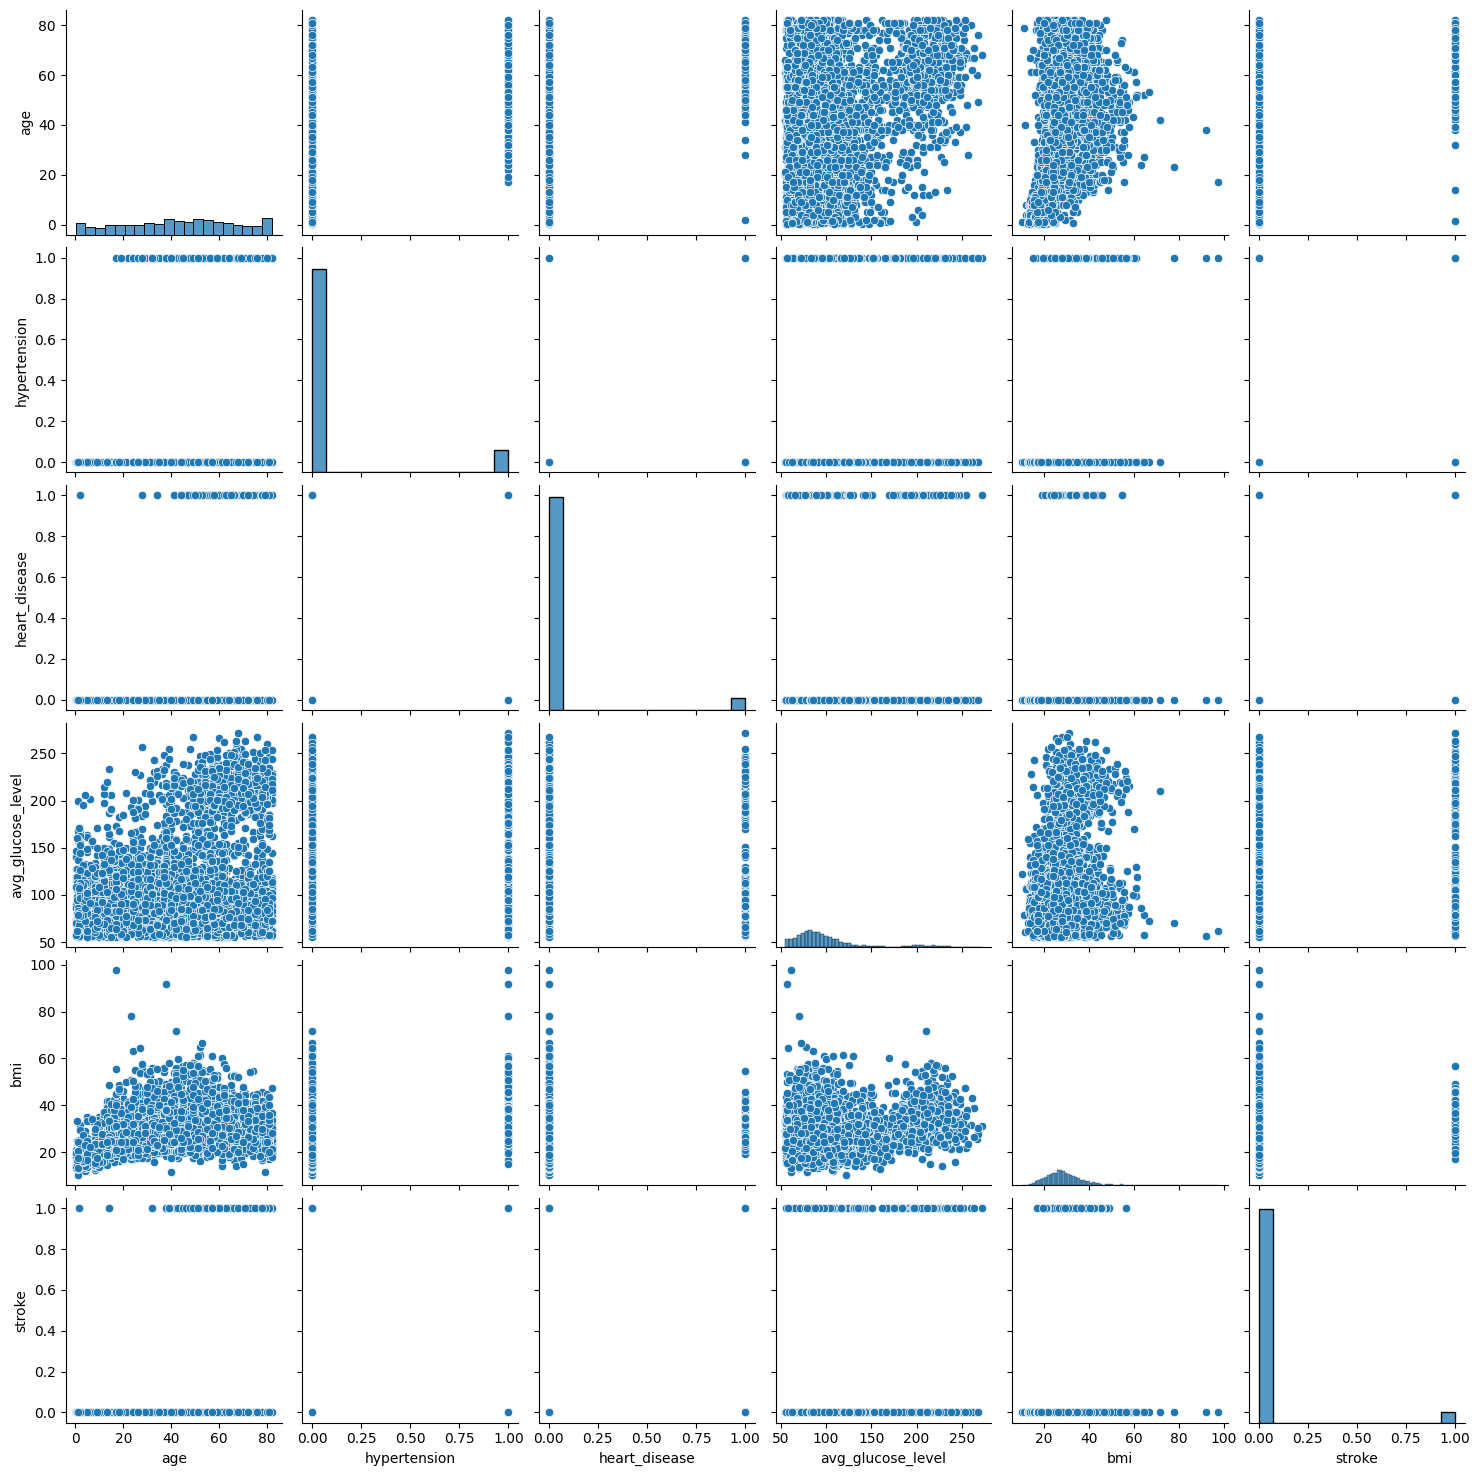

In [16]:
sns.pairplot(df)

/Users/reginasoh/.pyenv/versions/iod_proj_2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


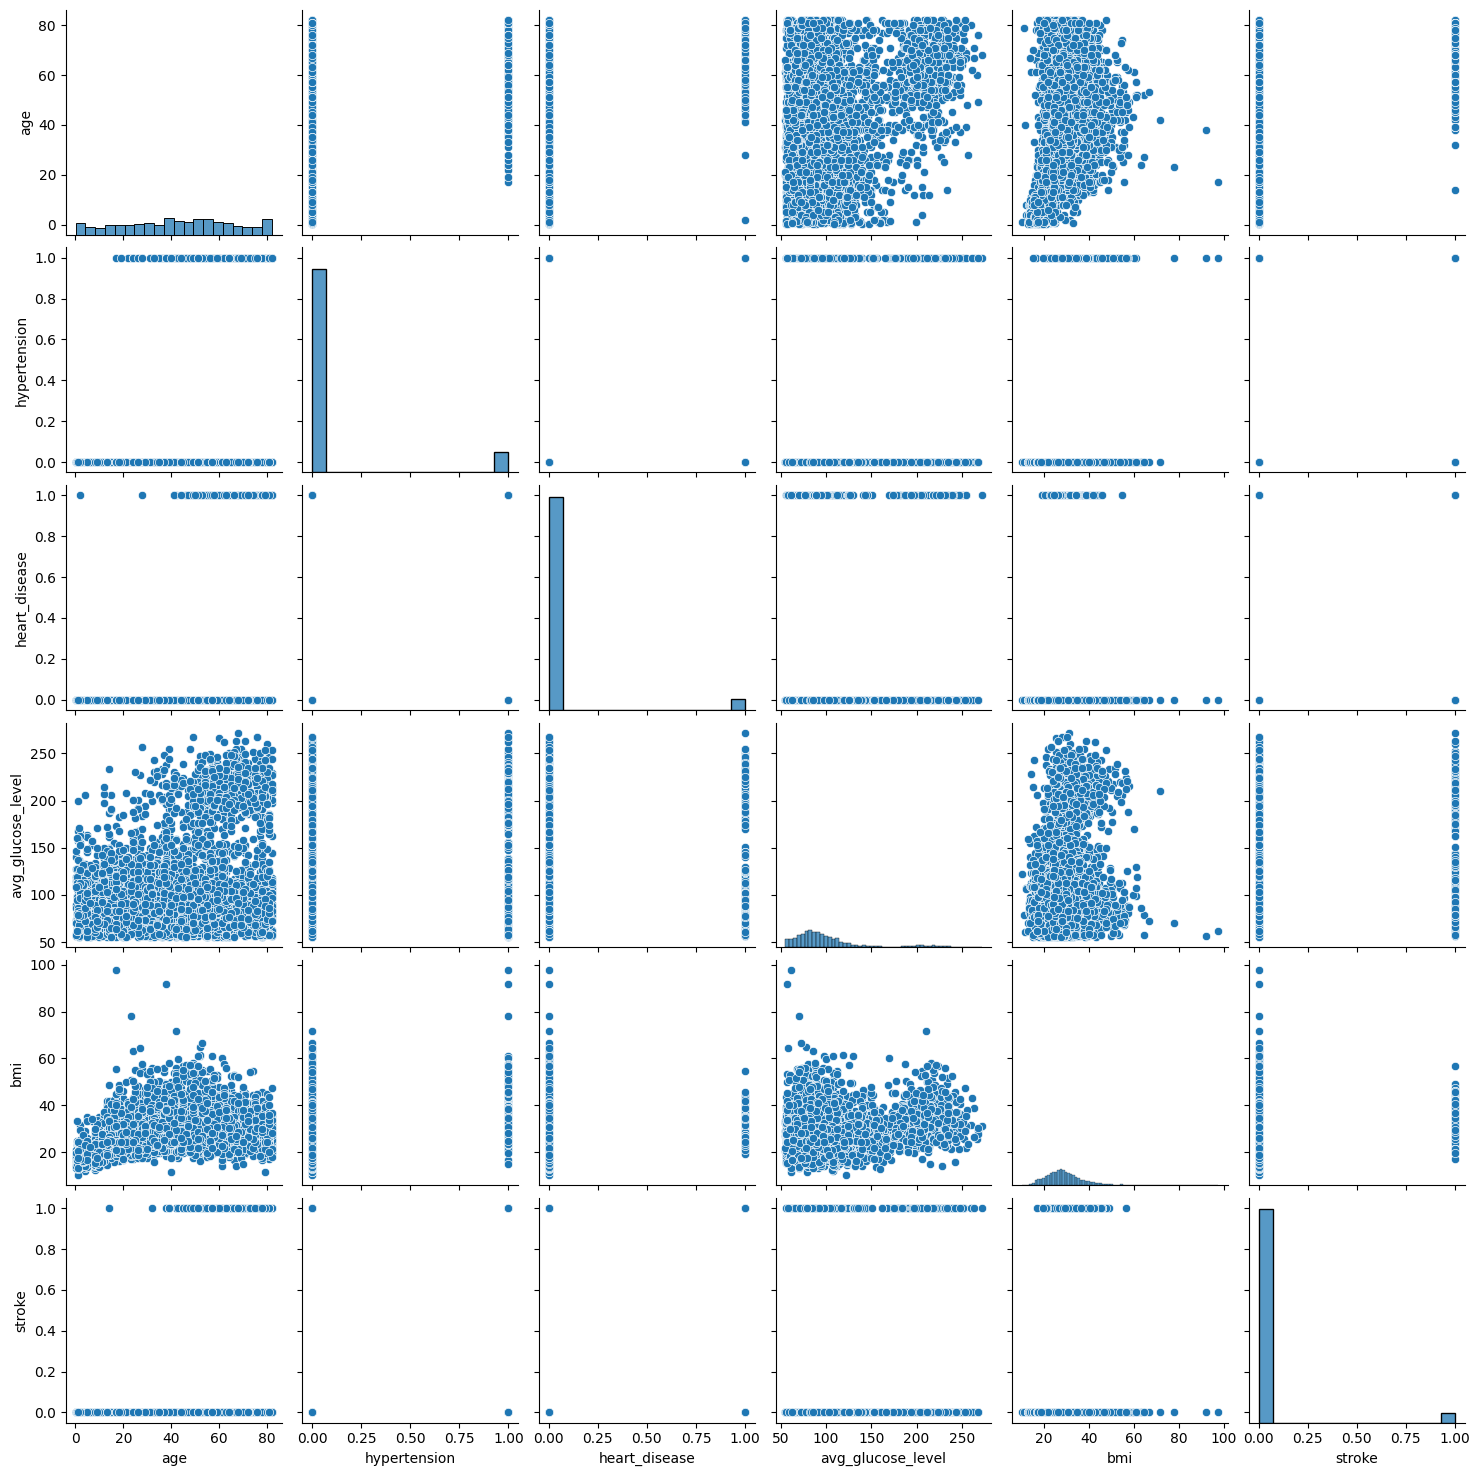

In [17]:
sns.pairplot(df[df['bmi'].isna()==False])

###  Handling missing BMI

In [18]:
df_cleaned = df.dropna(subset=['bmi'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


In [19]:
df_cleaned['gender'].value_counts()

gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

In [20]:
# To make model simpler, drop gender 'other' since there is only 1 patient
df_cleaned = df_cleaned[df_cleaned['gender'] != 'Other']
df_cleaned['gender'].value_counts()

gender
Female    2897
Male      2011
Name: count, dtype: int64

### Data Visualisation

In [21]:
bins = [0, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
labels = ['0-5', '6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55','56-60','61-65','66-70','71-75','76-80','81-85','86-90']
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins, labels = labels,include_lowest = True)



In [22]:
stroke = df_cleaned[df_cleaned['stroke'] == 1]
stroke['number_of_diseases']  = stroke['hypertension'] + stroke['heart_disease'] + stroke['stroke']

stroke

/var/folders/6g/2gnf02z56_3fdvcj9dlyc0gc0000gn/T/ipykernel_3734/4034894499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stroke['number_of_diseases']  = stroke['hypertension'] + stroke['heart_disease'] + stroke['stroke']


gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
56669    Male  81.0             0              0          Yes        Private   
...       ...   ...           ...            ...          ...            ...   
40460  Female  68.0             1              1          Yes        Private   
17739    Male  57.0             0              0          Yes        Private   
49669  Female  14.0             0              0           No       children   
27153  Female  75.0             0              0          Yes  Self-employed   
43424  Female  78.0             0              0          Yes        Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  \
id                                                                       
9046           Urban             228.69  36.6  formerly smoked       1   
31112          Rural             105.92  32.5     never smoked       1   
60182          Urban             171.23  34.4           smokes       1   
1665           Rural             174.12  24.0     never smoked       1   
56669          Urban             186.21  29.0  formerly smoked       1   
...              ...                ...   ...              ...     ...   
40460          Urban             247.51  40.5  formerly smoked       1   
17739          Rural              84.96  36.7          Unknown       1   
49669          Rural              57.93  30.9          Unknown       1   
27153          Rural              78.80  29.3  formerly smoked       1   
43424          Rural              78.81  19.6          Unknown       1   

      age_group  number_of_diseases  
id                                   
9046      66-70                   2  
31112     76-80                   2  
60182     46-50                   1  
1665      76-80                   2  
56669     81-85                   1  
...         ...                 ...  
40460     66-70                   3  
17739     56-60                   1  
49669     11-15                   1  
27153     71-75                   1  
43424     76-80                   1  

[209 rows x 13 columns]

In [23]:
age_gender = pd.pivot_table(df_cleaned, index=['age_group'], columns=['gender'], values= ['stroke'], aggfunc='count')
age_gender.columns  = age_gender.columns.droplevel(0)
age_gender.reset_index(inplace=True)
age_gender


age_gender_stroke = pd.pivot_table(stroke, index=['age_group'], columns=['gender'], values= ['stroke'],  aggfunc='count')
age_gender_stroke.columns  = age_gender_stroke.columns.droplevel(0)
age_gender_stroke.reset_index(inplace=True)
age_gender_stroke

gender age_group  Female  Male
0            0-5       0     0
1           6-10       0     0
2          11-15       1     0
3          16-20       0     0
4          21-25       0     0
5          26-30       0     0
6          31-35       1     0
7          36-40       4     0
8          41-45       2     3
9          46-50       7     3
10         51-55      11     4
11         56-60      12    15
12         61-65       5    10
13         66-70      16    11
14         71-75      14    10
15         76-80      35    22
16         81-85      12    11
17         86-90       0     0

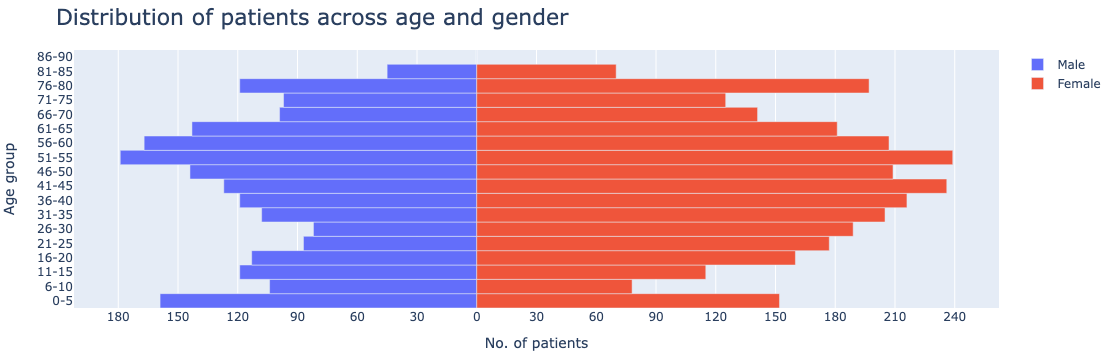

In [24]:
# Creating instance of the figure
fig = gp.Figure()
  
# Adding Male data to the figure
fig.add_trace(gp.Bar(y= age_gender['age_group'], x = age_gender['Male']*-1, 
                     name = 'Male', 
                     orientation = 'h'))
  
# Adding Female data to the figure
fig.add_trace(gp.Bar(y = age_gender['age_group'], x =age_gender['Female'],
                     name = 'Female', orientation = 'h'))
  
# Updating the layout for our graph
fig.update_layout(title = 'Distribution of patients across age and gender',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                xaxis = dict(tickvals = [-180,	-150,	-120,	-90,	-60,	-30,	0,	30,	60,	90,	120,	150,	180,	210, 240],
                            ticktext = ['180',	'150',	'120',	'90',	'60',	'30',	'0',	'30',	'60',	'90',	'120',	'150',	'180',	'210', '240'], 
                            title = 'No. of patients',
                            title_font_size = 14),
                 yaxis = dict(title='Age group',title_font_size = 14))


fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20)
    
)

fig.show()

In [25]:
df_cleaned['number_of_diseases'] = df_cleaned['hypertension'] + df_cleaned['heart_disease'] + df_cleaned['stroke']
no_of_diseases = pd.pivot_table(df_cleaned, index=['number_of_diseases'], columns=['gender'], values= ['age'], aggfunc='count')
no_of_diseases.columns  = no_of_diseases.columns.droplevel(0)
move_this_column = no_of_diseases.pop('Female')
no_of_diseases.insert(1, 'Female', move_this_column)
no_of_diseases
no_of_diseases

gender              Male  Female
number_of_diseases              
0                   1654    2498
1                    288     332
2                     63      62
3                      6       5

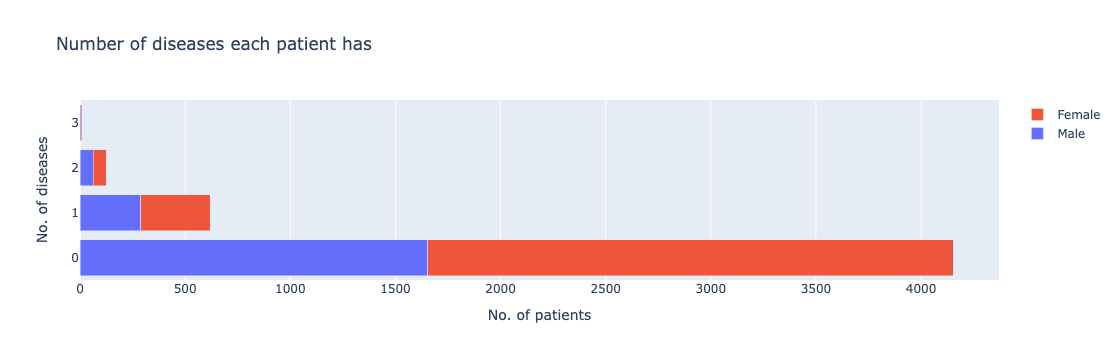

In [26]:
# Number of disease each age group has

fig = gp.Figure()
fig.add_trace(gp.Bar(
    y=no_of_diseases.index,
    x=no_of_diseases[no_of_diseases.columns[0]],
    name=no_of_diseases.columns[0],
    orientation='h',

    
))

for i in range(len(no_of_diseases.columns)-1):

    fig.add_trace(gp.Bar(
        y=no_of_diseases.index,
        x=no_of_diseases[no_of_diseases.columns[i+1]],
        name=no_of_diseases.columns[i+1],
        orientation='h'
    
    ))

fig.update_layout(barmode='stack', title = 'Number of diseases each patient has',
                  yaxis = dict(title='No. of diseases',title_font_size = 14),
                 xaxis = dict(title='No. of patients',title_font_size = 14))
fig.show()



In [27]:
stroke_or_not = df_cleaned[['stroke', 'gender','age']].groupby(['stroke', 'gender']).count()
stroke_or_not.reset_index(inplace=True)
stroke_or_not.rename(columns={"age": "count"}, inplace=True)
stroke_or_not['stroke'] = np.where(stroke_or_not['stroke'] == 1, 'Yes', 'No')
stroke_or_not

stroke  gender  count
0     No  Female   2777
1     No    Male   1922
2    Yes  Female    120
3    Yes    Male     89

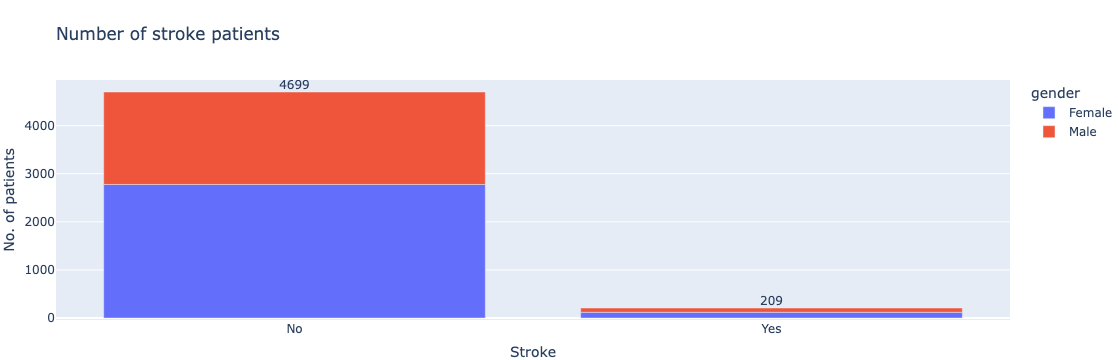

In [28]:
# Number of patients with and without stroke
total_group = stroke_or_not.groupby('stroke').sum()

fig = px.bar(stroke_or_not, x="stroke", y="count", color="gender", title="Number of stroke patients", labels={'count':'No. of patients', 'stroke': 'Stroke'})

fig.add_trace(gp.Scatter(
    x=total_group.index, 
    y=total_group['count'],
    text=total_group['count'],
    mode='text',
    textposition='top center',
    textfont=dict(
        size=12,
    ),
    showlegend=False
))

fig.update_layout(margin=dict(l=0, r=0, t=80, b=1))

fig.show()

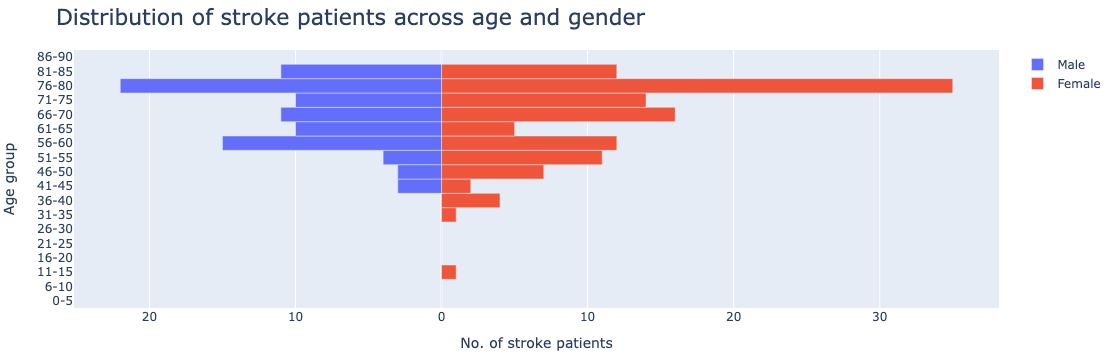

In [29]:
# Creating instance of the figure
fig = gp.Figure()
  
# Adding Male data to the figure
fig.add_trace(gp.Bar(y= age_gender_stroke['age_group'], x = age_gender_stroke['Male']*-1, 
                     name = 'Male', 
                     orientation = 'h'))
  
# Adding Female data to the figure
fig.add_trace(gp.Bar(y = age_gender_stroke['age_group'], x =age_gender_stroke['Female'],
                     name = 'Female', orientation = 'h'))
  
# Updating the layout for our graph
fig.update_layout(title = 'Distribution of stroke patients across age and gender',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                xaxis = dict(tickvals = [-30,-20,-10,0,10,20,30,40],
                            ticktext = ['30', '20', '10', '0', '10', '20', '30'], 
                            title = 'No. of stroke patients',
                            title_font_size = 14),
                 yaxis = dict(title='Age group',title_font_size = 14),
                 margin=dict(l=20, r=20, t=50, b=20))


fig.show()

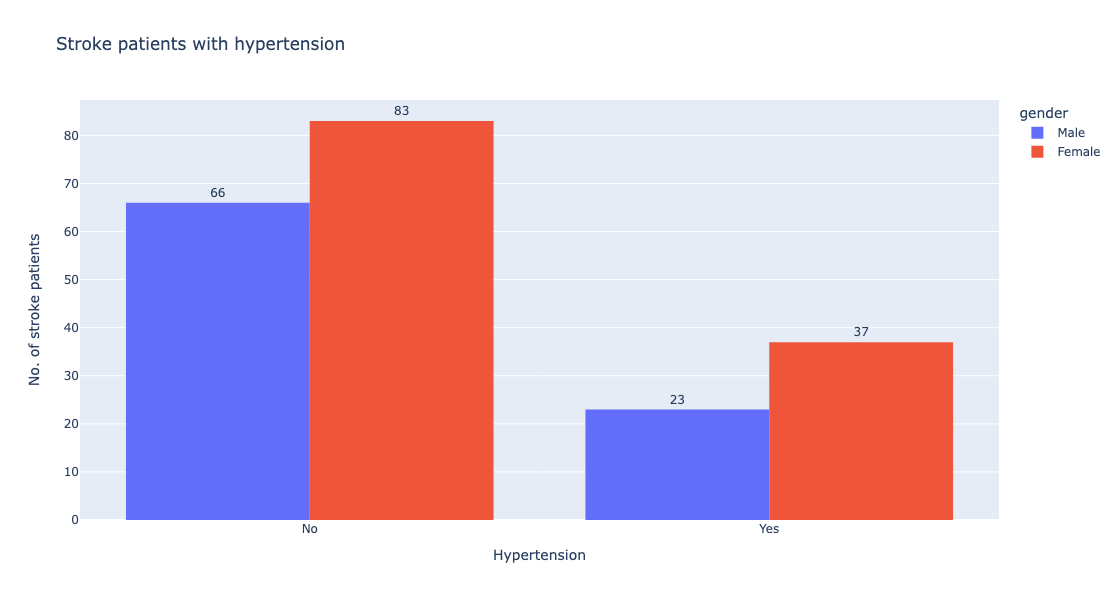

In [30]:
# No. of stroke cases with or without hypertension
fig = px.histogram(stroke, x="hypertension", y="stroke",
             color='gender', barmode='group',
             height=600, title='Stroke patients with hypertension', text_auto=True)

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.update_layout(xaxis = dict(tickvals = [0,1],
                            ticktext = ['No', 'Yes'], 
                            title = 'Hypertension',
                            title_font_size = 14),
                 yaxis = dict(title='No. of stroke patients',title_font_size = 14))
fig.show()

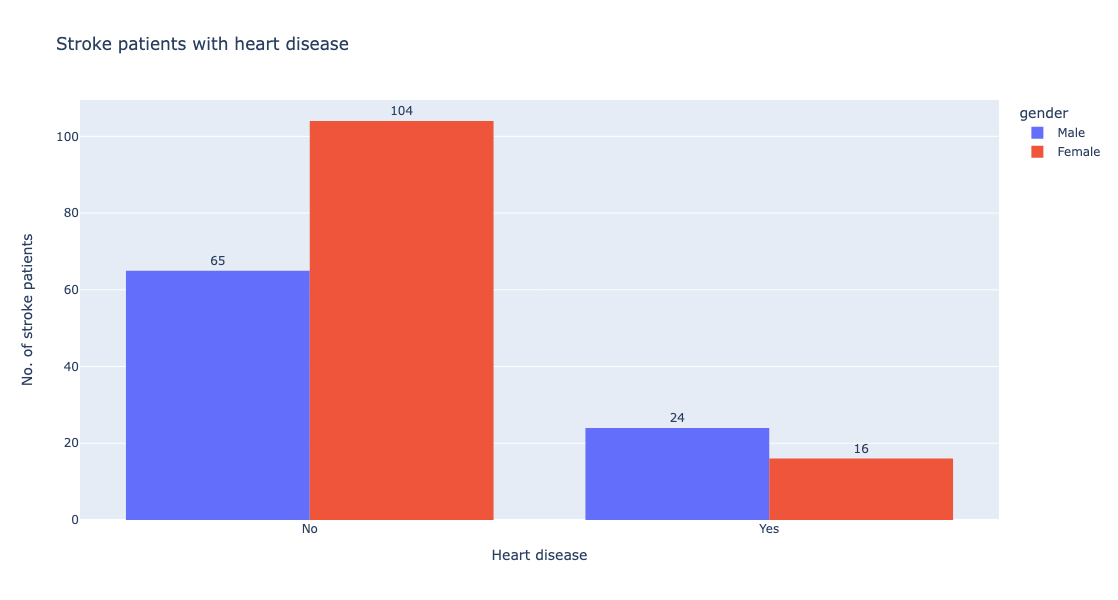

In [31]:
# No. of stroke cases with or without heart disease
fig = px.histogram(stroke, x="heart_disease", y="stroke",
             color='gender', barmode='group',
             height=600, title='Stroke patients with heart disease', text_auto=True)

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.update_layout(xaxis = dict(tickvals = [0,1],
                            ticktext = ['No', 'Yes'], 
                            title = 'Heart disease',
                            title_font_size = 14),
                 yaxis = dict(title='No. of stroke patients',title_font_size = 14))
fig.show()

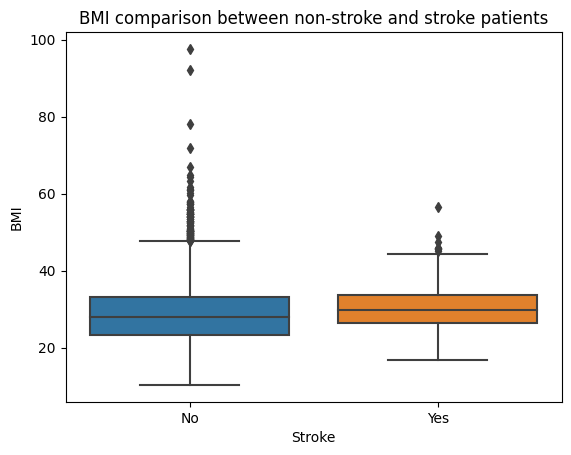

In [32]:
sns.boxplot(x='stroke',y='bmi',data = df_cleaned)

# Label the axes
plt.xlabel('Stroke') 
plt.ylabel('BMI')
plt.xticks([0,1],["No","Yes"])
plt.title('BMI comparison between non-stroke and stroke patients')
# Show the plot
plt.show()

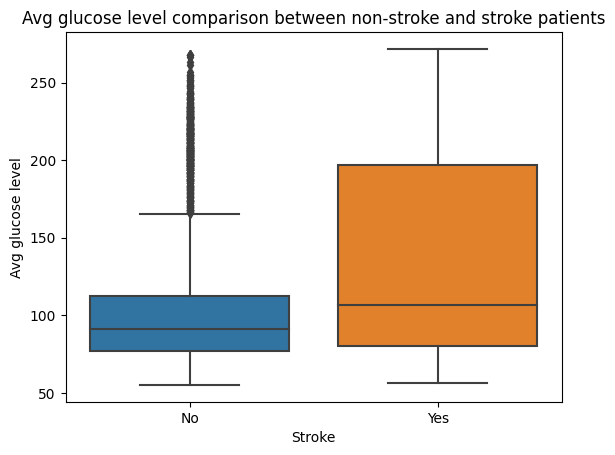

In [33]:
sns.boxplot(x='stroke',y='avg_glucose_level',data = df_cleaned)

# Label the axes
plt.xlabel('Stroke') 
plt.ylabel('Avg glucose level')
plt.xticks([0,1],["No","Yes"])
plt.title('Avg glucose level comparison between non-stroke and stroke patients')
# Show the plot
plt.show()

In [34]:
df_cleaned.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'number_of_diseases'],
      dtype='object')

## Data Preperation for modeling

In [35]:

df_dummy = pd.get_dummies(data = df_cleaned, columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'],drop_first=True, dtype=int)
df_dummy.drop(['age_group', 'number_of_diseases'],axis=1, inplace=True)
df_dummy

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
id                                                                          
9046   67.0             0              1             228.69  36.6       1   
31112  80.0             0              1             105.92  32.5       1   
60182  49.0             0              0             171.23  34.4       1   
1665   79.0             1              0             174.12  24.0       1   
56669  81.0             0              0             186.21  29.0       1   
...     ...           ...            ...                ...   ...     ...   
14180  13.0             0              0             103.08  18.6       0   
44873  81.0             0              0             125.20  40.0       0   
19723  35.0             0              0              82.99  30.6       0   
37544  51.0             0              0             166.29  25.6       0   
44679  44.0             0              0              85.28  26.2       0   

       gender_Male  ever_married_Yes  work_type_Never_worked  \
id                                                             
9046             1                 1                       0   
31112            1                 1                       0   
60182            0                 1                       0   
1665             0                 1                       0   
56669            1                 1                       0   
...            ...               ...                     ...   
14180            0                 0                       0   
44873            0                 1                       0   
19723            0                 1                       0   
37544            1                 1                       0   
44679            0                 1                       0   

       work_type_Private  work_type_Self-employed  work_type_children  \
id                                                                      
9046                   1                        0                   0   
31112                  1                        0                   0   
60182                  1                        0                   0   
1665                   0                        1                   0   
56669                  1                        0                   0   
...                  ...                      ...                 ...   
14180                  0                        0                   1   
44873                  0                        1                   0   
19723                  0                        1                   0   
37544                  1                        0                   0   
44679                  0                        0                   0   

       Residence_type_Urban  smoking_status_formerly smoked  \
id                                                            
9046                      1                               1   
31112                     0                               0   
60182                     1                               0   
1665                      0                               0   
56669                     1                               1   
...                     ...                             ...   
14180                     0                               0   
44873                     1                               0   
19723                     0                               0   
37544                     0                               1   
44679                     1                               0   

       smoking_status_never smoked  smoking_status_smokes  
id                                                         
9046                             0                      0  
31112                            1                      0  
60182                            0                      1  
1665                             1                      0  
56669                            0         

In [36]:
len(df_dummy.columns)

16

In [37]:

X = df_dummy[[c for c in df_dummy.columns if c != 'stroke']]
y = df_dummy['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

print('Original training dataset shape', Counter(y_train))

#smote = SMOTE(random_state=11, k_neighbors=4,sampling_strategy=0.1)
smote = SMOTE(random_state=11)


# fit predictor and target variable||
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Resample testing dataset shape', Counter(y_smote))

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_smote)
X_test_scaled = scaler.transform(X_test)

y_train = y_smote.copy()

Original training dataset shape Counter({0: 3759, 1: 167})
Resample testing dataset shape Counter({0: 3759, 1: 3759})


## Logistic Regression

In [38]:
## Tried to use gridsearch to find the best smote hyperparameters to get the highest f1 score but the result still poor

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# define the pipeline
estimator = Pipeline([
    ('smote', SMOTE(random_state=11)),
    ('scaler', StandardScaler()),
    ('classification',LogisticRegression())
])

# define the parameter grid
param_grid = {
    'smote__sampling_strategy': [0.1,0.3,0.5,0.7,0.9],
    'smote__k_neighbors': [1,2,3,4,5]
}


clf = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='f1'
)

clf.fit(X_train_smote, y_train_smote)
clf.best_score_
clf.score(X_test_smote, y_test_smote)
print(clf.best_params_, clf.best_score_,clf.score(X_test_smote, y_test_smote) )

{'smote__k_neighbors': 1, 'smote__sampling_strategy': 0.9} 0.17867514853033148 0.16304347826086954


In [39]:
# Fit Model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Score
print("training accuracy score:", lr.score(X_train_scaled, y_train))
print("testing accuracy score:", lr.score(X_test_scaled, y_test))

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

print("training F1 score:", f1_score(y_train, y_pred_train))
print("testing F1 score:", f1_score(y_test, y_pred_test))


training accuracy score: 0.8656557595105081
testing accuracy score: 0.8279022403258656
training F1 score: 0.8664021164021164
testing F1 score: 0.15075376884422112


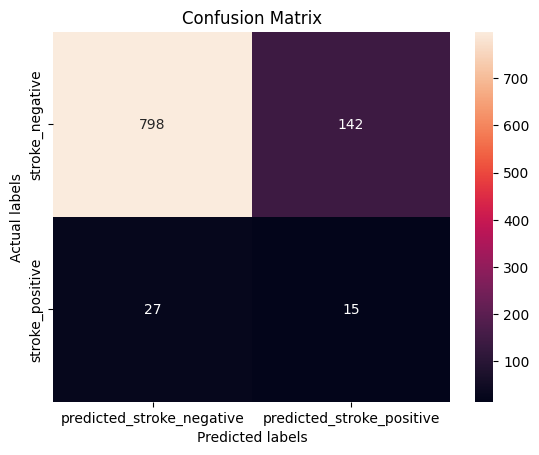

In [40]:
# Confusion matrix
y_pred_class = lr.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, y_pred_class)

columns=['predicted_stroke_negative', 'predicted_stroke_positive']
index=['stroke_negative', 'stroke_positive']


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(columns); ax.yaxis.set_ticklabels(index);

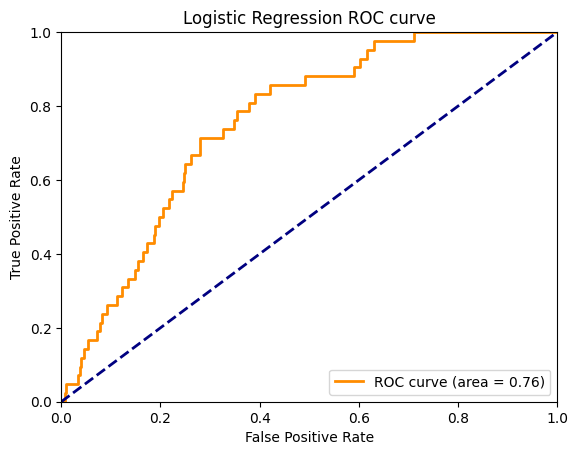

In [41]:
# ROC AUC
preds = lr.predict_proba(X_test_scaled)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc = "lower right")
plt.show()

### Logistic Regression with GridSearch

In [42]:
lr_params = {
    'penalty': ['l1','l2'], 
    'C': [1, 3, 5, 7, 10] 
}

# Create an lr classifier
lr_classifier =  LogisticRegression(solver='liblinear')

# Use GridSearchCV for hyperparameter tuning
lr_grid_search = GridSearchCV(lr_classifier, lr_params, cv=5, scoring='f1')
lr_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", lr_grid_search.best_params_)
print("Best F1 training score:", lr_grid_search.best_score_)

best_lr = lr_grid_search.best_estimator_
y_pred = best_lr.predict(X_test_scaled)
print("Best F1 testing score:", f1_score(y_test, y_pred))


Best Parameters: {'C': 1, 'penalty': 'l2'}
Best F1 training score: 0.8615353645556608
Best F1 testing score: 0.15075376884422112


In [43]:
best_lr.coef_

array([[ 2.36249456, -0.05231474, -0.127345  ,  0.37529578,  0.1813702 ,
        -0.44255428, -0.46175203, -0.19400547, -0.70290843, -0.83127508,
        -0.84680609, -0.52297612, -0.7242457 , -1.04503916, -0.52622983]])

### Logistic Regression with RFE

In [44]:
lreg = LogisticRegression()
lreg_rfe_model=RFE(estimator=lreg)
lreg_rfe_model_fit=lreg_rfe_model.fit(X_train_scaled,y_train)
feat_index = pd.Series(data = lreg_rfe_model_fit.ranking_, index = X_train.columns)
signi_feat_rfe = feat_index[feat_index==1].index
print('Significant features from RFE',signi_feat_rfe)

Significant features from RFE Index(['age', 'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [45]:
filter = lreg_rfe_model_fit.get_support()
X_train_scaled_lr = X_train_scaled[:,filter]
X_test_scaled_lr = X_test_scaled[:, filter]

lr = LogisticRegression()
lr.fit(X_train_scaled_lr, y_train)

# Score
print("training accuracy score:", lr.score(X_train_scaled_lr, y_train))
print("testing accuracy score:", lr.score(X_test_scaled_lr, y_test))

y_pred_train = lr.predict(X_train_scaled_lr)
y_pred_test = lr.predict(X_test_scaled_lr)

print("training F1 score:", f1_score(y_train, y_pred_train))
print("testing F1 score:", f1_score(y_test, y_pred_test))

training accuracy score: 0.8445065176908753
testing accuracy score: 0.7993890020366599
training F1 score: 0.8451040148403339
testing F1 score: 0.16170212765957448


In [46]:
lr_params = {
    'penalty': ['l1','l2'], 
    'C': [1, 3, 5, 7, 10] 
}

# Create an lr classifier
lr_classifier =  LogisticRegression(solver='liblinear')

# Use GridSearchCV for hyperparameter tuning
lr_grid_search = GridSearchCV(lr_classifier, lr_params, cv=5, scoring='f1')
lr_grid_search.fit(X_train_scaled_lr, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", lr_grid_search.best_params_)
print("Best F1 training score:", lr_grid_search.best_score_)

best_lr = lr_grid_search.best_estimator_
y_pred = best_lr.predict(X_test_scaled_lr)
print("Best F1 testing score:", f1_score(y_test, y_pred))

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best F1 training score: 0.8432612741582597
Best F1 testing score: 0.16170212765957448


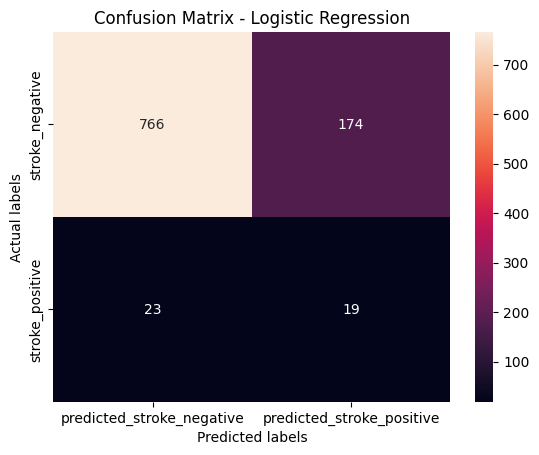

In [47]:
# Confusion matrix
y_pred_class = best_lr.predict(X_test_scaled_lr)
cm = metrics.confusion_matrix(y_test, y_pred_class)

columns=['predicted_stroke_negative', 'predicted_stroke_positive']
index=['stroke_negative', 'stroke_positive']


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix - Logistic Regression'); 
ax.xaxis.set_ticklabels(columns); ax.yaxis.set_ticklabels(index);

## SVM

In [48]:
svm = SVC(kernel = 'linear', C = 1000)

# Fit Model
svm.fit(X_train_scaled, y_train)

# Score
print("training score:", svm.score(X_train_scaled, y_train))
print("testing score:", svm.score(X_test_scaled, y_test))

y_pred_train = svm.predict(X_train_scaled)
y_pred_test = svm.predict(X_test_scaled)

print("training F1 score:", f1_score(y_train, y_pred_train))
print("testing F1 score:", f1_score(y_test, y_pred_test))


training score: 0.8635275339185954
testing score: 0.8329938900203666
training F1 score: 0.8632364702745935
testing F1 score: 0.14583333333333334


### SVM with RFE

In [49]:
svc_lin=SVC(kernel='linear')
svm_rfe_model=RFE(estimator=svc_lin)
svm_rfe_model_fit=svm_rfe_model.fit(X_train_scaled,y_train)
feat_index = pd.Series(data = svm_rfe_model_fit.ranking_, index = X_train.columns)
signi_feat_rfe = feat_index[feat_index==1].index
print('Significant features from RFE',signi_feat_rfe)

Significant features from RFE Index(['age', 'work_type_Private', 'work_type_Self-employed',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [50]:
filter = svm_rfe_model_fit.get_support()
X_train_scaled_svm = X_train_scaled[:,filter]
X_test_scaled_svm = X_test_scaled[:, filter]

svm = SVC()
svm.fit(X_train_scaled_svm, y_train)

# Score
print("training accuracy score:", svm.score(X_train_scaled_svm, y_train))
print("testing accuracy score:", svm.score(X_test_scaled_svm, y_test))

y_pred_train = svm.predict(X_train_scaled_svm)
y_pred_test = svm.predict(X_test_scaled_svm)

print("training F1 score:", f1_score(y_train, y_pred_train))
print("testing F1 score:", f1_score(y_test, y_pred_test))

training accuracy score: 0.8617983506251663
testing accuracy score: 0.8004073319755601
training F1 score: 0.8641652503595241
testing F1 score: 0.14782608695652175


In [51]:
# svc_lin=SVC(kernel='rbf')
# svm_rfe_model=RFE(estimator=svc_lin)
# svm_rfe_model_fit=svm_rfe_model.fit(X_train_scaled,y_train )
# feat_index = pd.Series(data = svm_rfe_model_fit.ranking_, index = X_train.columns)
# signi_feat_rfe = feat_index[feat_index==1].index
# print('Significant features from RFE',signi_feat_rfe)
# filter = svm_rfe_model_fit.get_support()
# X_train_scaled_svm = X_train_scaled[:,filter]
# X_test_scaled_svm = X_test_scaled[:, filter]

# svm = SVC()
# svm.fit(X_train_scaled_svm, y_train)

# # Score
# print("training accuracy score:", svm.score(X_train_scaled_svm, y_train))
# print("testing accuracy score:", svm.score(X_test_scaled_svm, y_test))

# y_pred_train = svm.predict(X_train_scaled_svm)
# y_pred_test = svm.predict(X_test_scaled_svm)

# print("training F1 score:", f1_score(y_train, y_pred_train))
# print("testing F1 score:", f1_score(y_test, y_pred_test))

### SVM with GridSearch (using RFE training and testing data model)

In [52]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001], 
    'kernel': ['linear','rbf']
}

# Create an SVM classifier
svm_classifier = SVC()

# Use GridSearchCV for hyperparameter tuning
svm_grid_search = GridSearchCV(svm_classifier, svc_params, cv=3,  scoring='f1')
svm_grid_search.fit(X_train_scaled_svm, y_train) 

# Print the best parameters and corresponding accuracy
print("Best Parameters:", svm_grid_search.best_params_)
print("Best F1 training score:", svm_grid_search.best_score_)

# Test the best model on the test set
best_svm = svm_grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled_svm)
print("Best F1 testing score:", f1_score(y_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Best F1 training score: 0.8608085362388115
Best F1 testing score: 0.18099547511312214


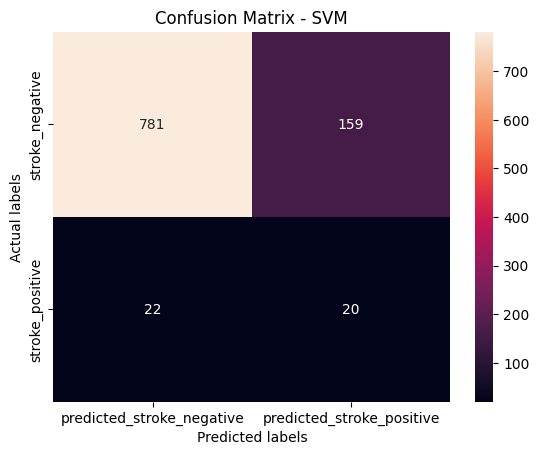

In [53]:
# Confusion matrix
y_pred_class = best_svm.predict(X_test_scaled_svm)
cm = metrics.confusion_matrix(y_test, y_pred_class)

columns=['predicted_stroke_negative', 'predicted_stroke_positive']
index=['stroke_negative', 'stroke_positive']


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix - SVM'); 
ax.xaxis.set_ticklabels(columns); ax.yaxis.set_ticklabels(index);

## KNN

In [54]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)

# Score
print("training accuracy score:", knn.score(X_train_scaled, y_train))
print("testing accuracy score:", knn.score(X_test_scaled, y_test))

y_pred_train = knn.predict(X_train_scaled)
y_pred_test = knn.predict(X_test_scaled)

print("training F1 score:", f1_score(y_train, y_pred_train))
print("testing F1 score:", f1_score(y_test, y_pred_test))

training accuracy score: 1.0
testing accuracy score: 0.8727087576374746
training F1 score: 1.0
testing F1 score: 0.12587412587412586


### KNN with GridSeach 

In [55]:
knn_params = {
    'n_neighbors': list(range(1,10,2))
}

# Create an SVM classifier
knn_classifier =  KNeighborsClassifier()

# Use GridSearchCV for hyperparameter tuning
knn_grid_search = GridSearchCV(knn_classifier, knn_params, cv=3,  scoring='f1')
knn_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", knn_grid_search.best_params_)
print("Best F1 training score:", knn_grid_search.best_score_)

# Test the best model on the test set
best_knn = knn_grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
print("Best F1 testing score:", f1_score(y_test, y_pred))

Best Parameters: {'n_neighbors': 1}
Best F1 training score: 0.9346987605508671
Best F1 testing score: 0.12587412587412586


In [56]:
list(range(1,10,2))

[1, 3, 5, 7, 9]

### KNN with PCA

Text(0, 0.5, 'cumulative explained variance')

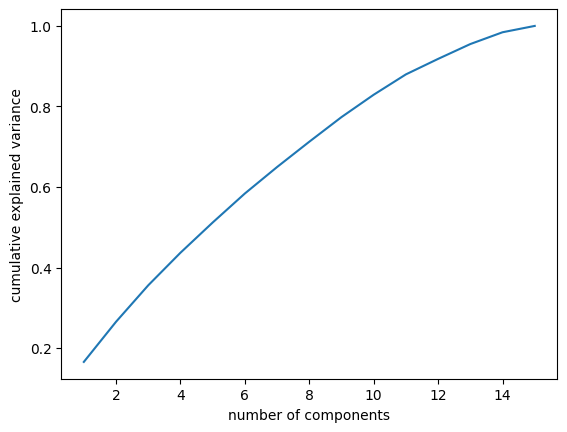

In [57]:
pca = PCA()

pca_features = pca.fit_transform(X_train_scaled)

variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1,len(variance_ratio)+1),np.cumsum(variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [58]:
index = range(1,len(variance_ratio)+1)
list(zip(index, np.cumsum(variance_ratio)))

[(1, 0.1655519739310981),
 (2, 0.26527065080563494),
 (3, 0.3558219702726207),
 (4, 0.436689997545498),
 (5, 0.5117224190540224),
 (6, 0.5838127202604443),
 (7, 0.649547872651068),
 (8, 0.712376419168744),
 (9, 0.7735761684715495),
 (10, 0.8291177687379372),
 (11, 0.879642157854388),
 (12, 0.9181277425663048),
 (13, 0.9549636765546532),
 (14, 0.9842559004965782),
 (15, 1.0000000000000002)]

In [59]:
# initiate PCA and classifier
pca = PCA(10) # at least 80% cumulative variance
knn_pca = KNeighborsClassifier(1)

# transform / fit
X_train_pca = pca.fit_transform(X_train_scaled)
knn_pca.fit(X_train_pca, y_train)

# transform new data using already fitted pca
# (don't re-fit the pca)
X_test_pca = pca.transform(X_test_scaled)
#clf.score(newdata_transformed, y_test) 

# score
#clf.score(newdata_transformed, y_test) 

y_pred_train = knn_pca.predict(X_train_pca)
print("Best F1 training score:", f1_score(y_train, y_pred_train))

y_pred_test = knn_pca.predict(X_test_pca)
print("Best F1 testing score:", f1_score(y_test, y_pred_test))


Best F1 training score: 1.0
Best F1 testing score: 0.1267605633802817


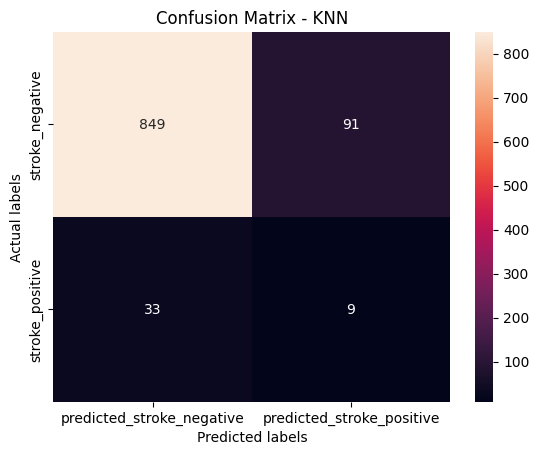

In [60]:
# Confusion matrix
y_pred_class = knn_pca.predict(X_test_pca)
cm = metrics.confusion_matrix(y_test, y_pred_class)

columns=['predicted_stroke_negative', 'predicted_stroke_positive']
index=['stroke_negative', 'stroke_positive']


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix - KNN'); 
ax.xaxis.set_ticklabels(columns); ax.yaxis.set_ticklabels(index);